In [1]:
import os
import sys
import datetime

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
from SRModels.loading_methods import load_dataset_as_patches
from SRModels.deep_learning_models.SRCNN_model import SRCNNModel
from SRModels.constants import SRCNN_PATCH_SIZE, SRCNN_STRIDE, RANDOM_SEED

In [2]:
HR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR"))
LR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR"))
INTERP_MAP_PATH = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/interpolation_map.pkl"))

In [3]:
# X -> Low-resolution patches (model input) (Low-resolution images with same size as Y but noised)
# Y -> High-resolution patches (target)
X, Y, hr_h, hr_w = load_dataset_as_patches(HR_ROOT, LR_ROOT, mode="srcnn", patch_size=SRCNN_PATCH_SIZE, stride=SRCNN_STRIDE, interpolation_map_path=INTERP_MAP_PATH)

# Reduce dataset size with percentage
X = X[:int(0.7 * len(X))]
Y = Y[:int(0.7 * len(Y))]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X shape: (333251, 24, 24, 3), Y shape: (333251, 24, 24, 3)
X_train shape: (269932, 24, 24, 3), Y_train shape: (269932, 24, 24, 3)
X_val shape: (29993, 24, 24, 3), Y_val shape: (29993, 24, 24, 3)
X_test shape: (33326, 24, 24, 3), Y_test shape: (33326, 24, 24, 3)


X_train range: [0.0000, 1.0000]
Y_train range: [0.0000, 1.0000]
NaN in X_train: False, NaN in Y_train: False


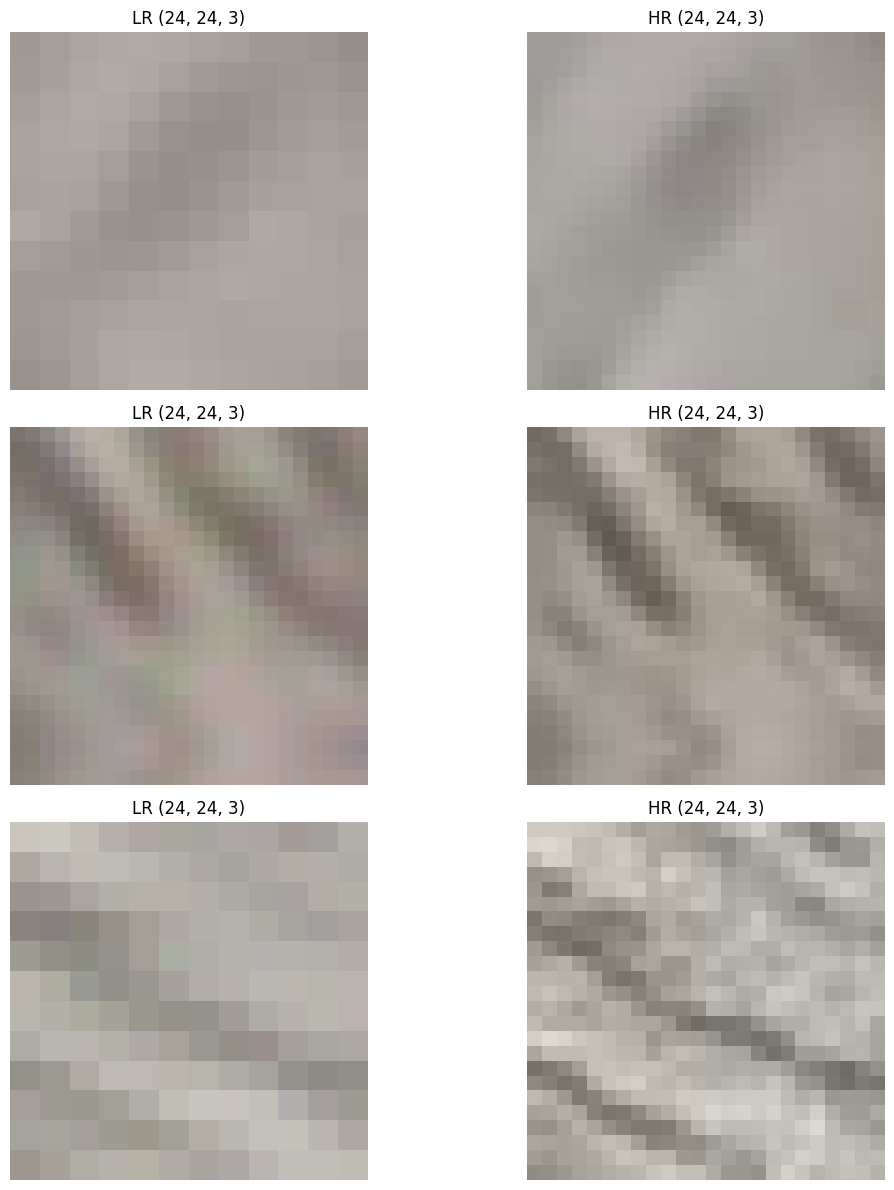

In [4]:
# Verificar rangos
print(f"X_train range: [{np.min(X_train):.4f}, {np.max(X_train):.4f}]")
print(f"Y_train range: [{np.min(Y_train):.4f}, {np.max(Y_train):.4f}]")
print(f"NaN in X_train: {np.isnan(X_train).any()}, NaN in Y_train: {np.isnan(Y_train).any()}")

# Visualizar algunos pares aleatorios
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    idx = np.random.randint(0, len(X_train))
    axes[i, 0].imshow(X_train[idx])
    axes[i, 0].set_title(f"LR {X_train[idx].shape}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(Y_train[idx])
    axes[i, 1].set_title(f"HR {Y_train[idx].shape}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
model = SRCNNModel()

model.setup_model(input_shape=X_train.shape[1:], learning_rate=1e-4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 96)        23424     
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        3104      
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 3)         2403      
                                                                 
Total params: 28,931
Trainable params: 28,931
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train SRCNN and capture callbacks for metrics
history, time_cb, mem_cb = model.fit(
    X_train, Y_train, X_val, Y_val,
    batch_size=32,
    epochs=50
)

Training on GPU: /physical_device:GPU:0
Epoch 1/50
8436/8436 [==============================] - 41s 4ms/step - loss: 0.0034 - psnr: 28.8328 - ssim: 0.7958 - val_loss: 0.0017 - val_psnr: 29.8603 - val_ssim: 0.8153 - lr: 1.0000e-04 - epoch_time_sec: 41.2931 - gpu_mean_current_mb: 3756.6384 - gpu_peak_mb: 3999.7483
Epoch 2/50
8436/8436 [==============================] - 36s 4ms/step - loss: 0.0017 - psnr: 30.0034 - ssim: 0.8149 - val_loss: 0.0016 - val_psnr: 30.2063 - val_ssim: 0.8159 - lr: 1.0000e-04 - epoch_time_sec: 35.8333 - gpu_mean_current_mb: 3954.4875 - gpu_peak_mb: 3999.7483
Epoch 3/50
8436/8436 [==============================] - ETA: 0s - loss: 0.0017 - psnr: 30.0871 - ssim: 0.8163
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
8436/8436 [==============================] - 36s 4ms/step - loss: 0.0017 - psnr: 30.0871 - ssim: 0.8163 - val_loss: 0.0016 - val_psnr: 30.1913 - val_ssim: 0.8185 - lr: 1.0000e-04 - epoch_time_sec: 36.2826 - gpu_mean_current_mb

In [7]:
# Evaluate and prepare metrics dictionary
results = model.evaluate(X_test, Y_test)

# Extract last epoch train/val metrics from history
train_loss = float(history.history['loss'][-1]) if 'loss' in history.history else None
val_loss = float(history.history['val_loss'][-1]) if 'val_loss' in history.history else None
train_psnr = float(history.history['psnr'][-1]) if 'psnr' in history.history else None
val_psnr = float(history.history['val_psnr'][-1]) if 'val_psnr' in history.history else None
train_ssim = float(history.history['ssim'][-1]) if 'ssim' in history.history else None
val_ssim = float(history.history['val_ssim'][-1]) if 'val_ssim' in history.history else None

metrics_dict = {
    "eval_loss": float(results[0]),
    "eval_psnr": float(results[1]),
    "eval_ssim": float(results[2]),
    "final_train_loss": train_loss,
    "final_val_loss": val_loss,
    "final_train_psnr": train_psnr,
    "final_val_psnr": val_psnr,
    "final_train_ssim": train_ssim,
    "final_val_ssim": val_ssim,
    "epoch_time_sec": time_cb.mean_time_value(),
    "memory": mem_cb.as_dict()
}

1042/1042 [==============================] - 5s 5ms/step - loss: 0.0016 - psnr: 30.3599 - ssim: 0.8222
Loss: 0.0016, PSNR: 30.36 dB, SSIM: 0.8222


In [8]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the trained model
model.save(directory=f"models/SRCNN/SRCNN_{timestamp}", timestamp=timestamp)

# Save hr_h and hr_w for later use in the reconstruction of the images
with open(os.path.abspath(os.path.join(os.getcwd(), f"models/SRCNN/SRCNN_{timestamp}/SRCNN_{timestamp}_hrh_hrw.pkl")), "wb") as f:
    pickle.dump((hr_h, hr_w), f)

Model saved to models/SRCNN/SRCNN_20250910_014014\SRCNN_20250910_014014.h5


In [9]:
# Save evaluation/time/memory metrics next to the model
metrics_path = os.path.abspath(os.path.join(os.getcwd(), f"models/SRCNN/SRCNN_{timestamp}/SRCNN_{timestamp}_metrics.pkl"))

with open(metrics_path, "wb") as f:
    pickle.dump(metrics_dict, f)
    
print(f"Saved metrics to {metrics_path}")

Saved metrics to c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\SRCNN\SRCNN_20250910_014014\SRCNN_20250910_014014_metrics.pkl
